首先，让我们通过调用d2l.load_data_ptb函数来获得该数据集的数据迭代器和词表

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

我们通过嵌入层和批量矩阵乘法实现了跳元模型。首先，让我们回顾一下嵌入层是如何工作的。

嵌入层将词元的索引映射到其特征向量。该层的权重是一个矩阵，其行数等于字典大小（input_dim），列数等于每个标记的向量维数（output_dim）。在词嵌入模型训练之后，这个权重就是我们所需要的。

In [2]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [3]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-1.4044, -0.5216,  1.2766, -1.3052],
         [ 0.3780,  0.7025, -1.3748, -0.3479],
         [-0.0861,  1.2724, -0.1756,  0.2280]],

        [[-0.1660, -0.2639,  1.8242,  1.0447],
         [ 0.0783,  0.1729,  1.3621, -0.5476],
         [-0.7823, -0.8015,  0.0939, -0.5603]]], grad_fn=<EmbeddingBackward0>)

定义前向传播

在前向传播中，跳元语法模型的输入包括形状为（批量大小，1）的中心词索引center和形状为（批量大小，max_len）的上下文与噪声词索引contexts_and_negatives。这两个变量首先通过嵌入层从词元索引转换成向量，然后它们的批量矩阵相乘返回形状为（批量大小，1，max_len）的输出。输出中的每个元素是中心词向量和上下文或噪声词向量的点积。

In [4]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

让我们为一些样例输入打印此skip_gram函数的输出形状。

In [5]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

使用二元交叉熵损失。

In [6]:
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

下面计算给定变量的二进制交叉熵损失。

In [7]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

下面显示了如何使用二元交叉熵损失中的Sigmoid激活函数（以较低效率的方式）计算上述结果。我们可以将这两个输出视为两个规范化的损失，在非掩码预测上进行平均。

In [8]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


初始化模型参数

定义了两个嵌入层，将词表中的所有单词分别作为中心词和上下文词使用。字向量维度embed_size被设置为100。

In [9]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

定义训练阶段代码

In [10]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]
            # 可以看出，是自己预测自己 
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.410, 651970.5 tokens/sec on cuda:0


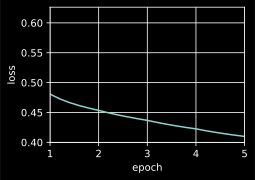

In [11]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

应用词嵌入

在训练word2vec模型之后，可以使用训练好模型中词向量的余弦相似度来从词表中找到与输入单词语义最相似的单词。

In [12]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.754: microprocessor
cosine sim=0.683: desktop
cosine sim=0.665: intel


如果想要实现使用embedding的话，这个矩阵显然太小了，而且我们之前论文中看到的各种加速方法也没用上

In [13]:
embed.weight.data

tensor([[-0.9456,  0.8201,  0.6553,  0.4597],
        [-1.4044, -0.5216,  1.2766, -1.3052],
        [ 0.3780,  0.7025, -1.3748, -0.3479],
        [-0.0861,  1.2724, -0.1756,  0.2280],
        [-0.1660, -0.2639,  1.8242,  1.0447],
        [ 0.0783,  0.1729,  1.3621, -0.5476],
        [-0.7823, -0.8015,  0.0939, -0.5603],
        [ 0.5840,  0.5511, -0.3615,  0.1508],
        [-0.9907, -2.3468,  0.3705,  0.6358],
        [-0.4909,  0.8642, -1.1599,  0.7922],
        [-0.3260,  1.1503, -0.7174,  0.9421],
        [-1.1432,  0.0743,  1.2143,  0.1892],
        [ 0.7149, -0.4063,  0.5767, -0.7643],
        [-1.3713, -0.2981, -0.9881,  1.6511],
        [ 1.4157,  1.2021, -1.5375,  0.3114],
        [ 0.6059, -2.4393, -0.8745, -2.2409],
        [ 0.1188,  1.4413,  0.4627,  1.1435],
        [-0.3528, -0.6449, -0.5806, -2.6435],
        [-1.3726, -1.1327,  0.9520,  0.4326],
        [-0.4298, -1.1344,  0.9505,  0.2920]])